# PACS Domain Generalization with Vision Transformer (ViT)

## Setup and Imports

In [8]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
# Corrected import: Use an alias for the imported ViTModel to avoid name collision
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTModel as ViTModelBase
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

## Configuration and Seeds

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
SEED = 42
BATCH_SIZE = 24
NUM_EPOCHS = 5
NUM_CLASSES = 7
DATA_ROOT = "../../../pacs_data/pacs_data"
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]
MODELS = {
    "base": "google/vit-base-patch16-224-in21k",
    "small": "WinKawaks/vit-small-patch16-224",
    "tiny": "WinKawaks/vit-tiny-patch16-224"
    }

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Device: cuda


## Dataset Wrapper Class

In [10]:
class PACSDataset:
    def __init__(self, data_root, domains, transform):
        self.data_root = data_root
        self.domains = domains
        self.transform = transform

    def get_dataloader(self, domain, train=True):
        dataset = datasets.ImageFolder(os.path.join(self.data_root, domain), transform=self.transform)
        
        indices = list(range(len(dataset)))
        train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=[dataset.targets[i] for i in indices], random_state=SEED)
        selected_idx = train_idx if train else val_idx
        
        subset = Subset(dataset, selected_idx)
        loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=train)
        return loader

## Vision Transformer Wrapper Class

In [11]:
class ViTModel(nn.Module):
    def __init__(self, num_classes, model_size="base"):
        super(ViTModel, self).__init__()
        # Change 1: Load the base ViTModel using the alias 'ViTModelBase'
        self.model = ViTModelBase.from_pretrained(
            MODELS[model_size]
        )
        
        # Change 2: Define our custom "thinking" head
        hidden_size = self.model.config.hidden_size # This is 768 for the base model
        self.classifier_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        # Change 3: Update the forward pass logic
        # Pass input through the base model
        outputs = self.model(x)
        # Get the feature vector for the [CLS] token
        cls_token_features = outputs.last_hidden_state[:, 0, :]
        # Pass the features through our custom head
        logits = self.classifier_head(cls_token_features)
        return logits

## Trainer Class

In [12]:
class Trainer:
    def __init__(self, model, optimizer, criterion):
        self.model = model.to(DEVICE)
        self.optimizer = optimizer
        self.criterion = criterion

    def train(self, dataloader):
        self.model.train()
        total_loss = 0
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def evaluate(self, dataloader):
        self.model.eval()
        
        # Change 1: Manually set the dropout layers in our custom head to train mode
        # This keeps them active during evaluation for Monte Carlo Dropout
        for module in self.model.classifier_head.modules():
            if isinstance(module, nn.Dropout):
                module.train()

        total_correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                
                # Change 2: Perform N=20 forward passes to get an ensemble of predictions
                ensemble_preds = []
                for _ in range(20): # N=20 passes
                    outputs = self.model(inputs)
                    preds = torch.argmax(outputs, dim=1)
                    ensemble_preds.append(preds.unsqueeze(0))
                
                # Change 3: Calculate the majority vote for the final prediction
                stacked_preds = torch.cat(ensemble_preds, dim=0)
                final_preds, _ = torch.mode(stacked_preds, dim=0)

                total_correct += (final_preds == labels).sum().item()
                total += labels.size(0)
        return total_correct / total

# Stochastic Ensemble ViT

## Leave-One-Domain-Out (LODO) Training

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

results_base = {}

for test_domain in DOMAINS:
    print(f"\nTesting on domain: {test_domain}")
    train_domains = [d for d in DOMAINS if d != test_domain]

    # Load datasets
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)

    # Concatenate datasets
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, and criterion
    model_base = ViTModel(NUM_CLASSES, model_size="base")
    optimizer = optim.Adam(model_base.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model_base, optimizer, criterion)

    # Train
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        train_loss_base = trainer.train(train_loader)
        val_acc_base = trainer.evaluate(val_loader)
        print(f"Train Loss: {train_loss_base:.4f} | Val Acc: {val_acc_base:.4f}")

    # Test
    test_acc_base = trainer.evaluate(test_loader)
    results_base[test_domain] = test_acc_base
    print(f"Test Accuracy on {test_domain}: {test_acc_base:.4f}")


Testing on domain: art_painting
Epoch 1/5


100%|██████████| 265/265 [01:21<00:00,  3.24it/s]


Train Loss: 0.7092 | Val Acc: 0.9339
Epoch 2/5


100%|██████████| 265/265 [00:32<00:00,  8.21it/s]


Train Loss: 0.1283 | Val Acc: 0.9207
Epoch 3/5


100%|██████████| 265/265 [00:32<00:00,  8.21it/s]


Train Loss: 0.0616 | Val Acc: 0.9547
Epoch 4/5


100%|██████████| 265/265 [00:32<00:00,  8.23it/s]


Train Loss: 0.0558 | Val Acc: 0.9559
Epoch 5/5


100%|██████████| 265/265 [00:32<00:00,  8.27it/s]


Train Loss: 0.0387 | Val Acc: 0.9629
Test Accuracy on art_painting: 0.8927

Testing on domain: cartoon
Epoch 1/5


100%|██████████| 255/255 [00:38<00:00,  6.55it/s]


Train Loss: 0.7122 | Val Acc: 0.9471
Epoch 2/5


100%|██████████| 255/255 [00:30<00:00,  8.23it/s]


Train Loss: 0.1433 | Val Acc: 0.9542
Epoch 3/5


100%|██████████| 255/255 [00:30<00:00,  8.28it/s]


Train Loss: 0.0777 | Val Acc: 0.9471
Epoch 4/5


100%|██████████| 255/255 [00:30<00:00,  8.24it/s]


Train Loss: 0.0694 | Val Acc: 0.9399
Epoch 5/5


100%|██████████| 255/255 [00:30<00:00,  8.25it/s]


Train Loss: 0.0399 | Val Acc: 0.9542
Test Accuracy on cartoon: 0.8060

Testing on domain: photo
Epoch 1/5


100%|██████████| 278/278 [00:33<00:00,  8.20it/s]


Train Loss: 0.7486 | Val Acc: 0.9129
Epoch 2/5


100%|██████████| 278/278 [00:32<00:00,  8.54it/s]


Train Loss: 0.1506 | Val Acc: 0.9459
Epoch 3/5


100%|██████████| 278/278 [00:31<00:00,  8.79it/s]


Train Loss: 0.0707 | Val Acc: 0.9423
Epoch 4/5


100%|██████████| 278/278 [00:31<00:00,  8.81it/s]


Train Loss: 0.0496 | Val Acc: 0.9423
Epoch 5/5


100%|██████████| 278/278 [00:31<00:00,  8.82it/s]


Train Loss: 0.0508 | Val Acc: 0.9387
Test Accuracy on photo: 0.9731

Testing on domain: sketch
Epoch 1/5


100%|██████████| 203/203 [00:23<00:00,  8.60it/s]


Train Loss: 0.6803 | Val Acc: 0.9448
Epoch 2/5


100%|██████████| 203/203 [00:23<00:00,  8.67it/s]


Train Loss: 0.0988 | Val Acc: 0.9472
Epoch 3/5


100%|██████████| 203/203 [00:23<00:00,  8.65it/s]


Train Loss: 0.0433 | Val Acc: 0.9695
Epoch 4/5


100%|██████████| 203/203 [00:23<00:00,  8.56it/s]


Train Loss: 0.0395 | Val Acc: 0.9629
Epoch 5/5


100%|██████████| 203/203 [00:23<00:00,  8.70it/s]


Train Loss: 0.0313 | Val Acc: 0.9786
Test Accuracy on sketch: 0.6450


## Baseline

In [14]:
print("\Baseline: training on all domains and testing on mixed domains")
# Load full train and test sets via leave-all-in loaders
dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]

# Concatenate
full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Initialize baseline model
baseline_model_base = ViTModel(NUM_CLASSES, model_size="base")
baseline_optimizer = optim.Adam(baseline_model_base.parameters(), lr=1e-4)
baseline_criterion = nn.CrossEntropyLoss()
baseline_trainer = Trainer(baseline_model_base, baseline_optimizer, baseline_criterion)

# Train baseline
for epoch in range(NUM_EPOCHS):
    print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
    baseline_loss_base = baseline_trainer.train(full_train_loader)
    baseline_val_acc_base = baseline_trainer.evaluate(full_test_loader)
    print(f"Baseline Loss: {baseline_loss_base:.4f} | Baseline Acc: {baseline_val_acc_base:.4f}")

# Test baseline
baseline_test_acc_base = baseline_trainer.evaluate(full_test_loader)
results_base['baseline_all_domains'] = baseline_test_acc_base
print(f"Baseline Test Accuracy: {baseline_test_acc_base:.4f}")

\Baseline: training on all domains and testing on mixed domains


<>:1: SyntaxWarning: invalid escape sequence '\B'
<>:1: SyntaxWarning: invalid escape sequence '\B'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_14976\2082205452.py:1: SyntaxWarning: invalid escape sequence '\B'
  print("\Baseline: training on all domains and testing on mixed domains")


Baseline Epoch 1/5


100%|██████████| 333/333 [00:38<00:00,  8.70it/s]


Baseline Loss: 0.5954 | Baseline Acc: 0.9530
Baseline Epoch 2/5


100%|██████████| 333/333 [00:38<00:00,  8.76it/s]


Baseline Loss: 0.1162 | Baseline Acc: 0.9500
Baseline Epoch 3/5


100%|██████████| 333/333 [00:38<00:00,  8.72it/s]


Baseline Loss: 0.0763 | Baseline Acc: 0.9560
Baseline Epoch 4/5


100%|██████████| 333/333 [00:38<00:00,  8.67it/s]


Baseline Loss: 0.0582 | Baseline Acc: 0.9440
Baseline Epoch 5/5


100%|██████████| 333/333 [00:38<00:00,  8.65it/s]


Baseline Loss: 0.0367 | Baseline Acc: 0.9120
Baseline Test Accuracy: 0.9105


## Visual Comparison

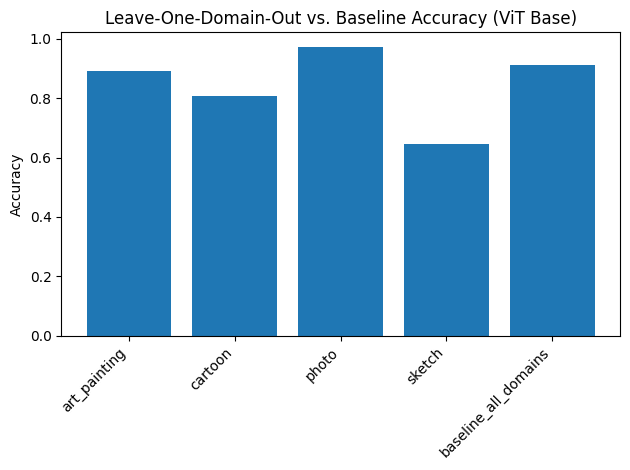

In [15]:
domains = list(results_base.keys())
accuracies = [results_base[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy (ViT Base)')
plt.tight_layout()
plt.show()

## Final Results

In [16]:
print("\Final Results (LODO Accuracy):")
for domain, acc in results_base.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_base.values()) / len(results_base)
print(f"\nAverage Accuracy: {avg_acc:.4f}")

\Final Results (LODO Accuracy):
art_painting: 0.8927
cartoon: 0.8060
photo: 0.9731
sketch: 0.6450
baseline_all_domains: 0.9105

Average Accuracy: 0.8454


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_14976\945372892.py:1: SyntaxWarning: invalid escape sequence '\F'
  print("\Final Results (LODO Accuracy):")


# WinKawaks/ViT Small

Leave-One-Domain-Out (LODO) Training

In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

results_small = {}

for test_domain in DOMAINS:
    print(f"\Testing on domain: {test_domain}")
    train_domains = [d for d in DOMAINS if d != test_domain]

    # Load datasets
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)

    # Concatenate datasets
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, and criterion
    model_small = ViTModel(NUM_CLASSES, model_size="small")
    optimizer = optim.Adam(model_small.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model_small, optimizer, criterion)

    # Train
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        train_loss_small = trainer.train(train_loader)
        val_acc_small = trainer.evaluate(val_loader)
        print(f"Train Loss: {train_loss_small:.4f} | Val Acc: {val_acc_small:.4f}")

    # Test
    test_acc_small = trainer.evaluate(test_loader)
    results_small[test_domain] = test_acc_small
    print(f"Test Accuracy on {test_domain}: {test_acc_small:.4f}")

\Testing on domain: art_painting


<>:10: SyntaxWarning: invalid escape sequence '\T'
<>:10: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_14976\1278890614.py:10: SyntaxWarning: invalid escape sequence '\T'
  print(f"\Testing on domain: {test_domain}")
Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 265/265 [00:17<00:00, 15.54it/s]


Train Loss: 0.6611 | Val Acc: 0.9346
Epoch 2/5


100%|██████████| 265/265 [00:16<00:00, 15.84it/s]


Train Loss: 0.1739 | Val Acc: 0.9509
Epoch 3/5


100%|██████████| 265/265 [00:16<00:00, 15.82it/s]


Train Loss: 0.1109 | Val Acc: 0.9295
Epoch 4/5


100%|██████████| 265/265 [00:16<00:00, 15.68it/s]


Train Loss: 0.0948 | Val Acc: 0.9459
Epoch 5/5


100%|██████████| 265/265 [00:16<00:00, 15.64it/s]


Train Loss: 0.0605 | Val Acc: 0.9641
Test Accuracy on art_painting: 0.8317
\Testing on domain: cartoon


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 255/255 [00:16<00:00, 15.46it/s]


Train Loss: 0.5972 | Val Acc: 0.9405
Epoch 2/5


100%|██████████| 255/255 [00:16<00:00, 15.64it/s]


Train Loss: 0.1741 | Val Acc: 0.9510
Epoch 3/5


100%|██████████| 255/255 [00:16<00:00, 15.61it/s]


Train Loss: 0.1107 | Val Acc: 0.9346
Epoch 4/5


100%|██████████| 255/255 [00:16<00:00, 15.69it/s]


Train Loss: 0.0995 | Val Acc: 0.9451
Epoch 5/5


100%|██████████| 255/255 [00:16<00:00, 15.66it/s]


Train Loss: 0.0717 | Val Acc: 0.9425
Test Accuracy on cartoon: 0.7953
\Testing on domain: photo


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 278/278 [00:18<00:00, 15.16it/s]


Train Loss: 0.6547 | Val Acc: 0.9177
Epoch 2/5


100%|██████████| 278/278 [00:18<00:00, 15.31it/s]


Train Loss: 0.1984 | Val Acc: 0.8823
Epoch 3/5


100%|██████████| 278/278 [00:17<00:00, 16.14it/s]


Train Loss: 0.1085 | Val Acc: 0.9345
Epoch 4/5


100%|██████████| 278/278 [00:17<00:00, 16.12it/s]


Train Loss: 0.1036 | Val Acc: 0.9315
Epoch 5/5


100%|██████████| 278/278 [00:17<00:00, 16.03it/s]


Train Loss: 0.0802 | Val Acc: 0.9177
Test Accuracy on photo: 0.9671
\Testing on domain: sketch


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 203/203 [00:13<00:00, 15.57it/s]


Train Loss: 0.5389 | Val Acc: 0.9497
Epoch 2/5


100%|██████████| 203/203 [00:12<00:00, 15.84it/s]


Train Loss: 0.1486 | Val Acc: 0.9571
Epoch 3/5


100%|██████████| 203/203 [00:12<00:00, 15.88it/s]


Train Loss: 0.1151 | Val Acc: 0.9547
Epoch 4/5


100%|██████████| 203/203 [00:12<00:00, 15.84it/s]


Train Loss: 0.0257 | Val Acc: 0.9547
Epoch 5/5


100%|██████████| 203/203 [00:12<00:00, 15.83it/s]


Train Loss: 0.0522 | Val Acc: 0.9192
Test Accuracy on sketch: 0.5382


## Baseline

In [18]:
print("\nBaseline: training on all domains and testing on mixed domains")
# Load full train and test sets via leave-all-in loaders
dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]

# Concatenate
full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Initialize baseline model
# CORRECTED: Added model_size="small" to ensure the correct model is loaded.
baseline_model_small = ViTModel(NUM_CLASSES, model_size="small")
baseline_optimizer = optim.Adam(baseline_model_small.parameters(), lr=1e-4)
baseline_criterion = nn.CrossEntropyLoss()
baseline_trainer = Trainer(baseline_model_small, baseline_optimizer, baseline_criterion)

# Train baseline
for epoch in range(NUM_EPOCHS):
    print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
    baseline_loss_small = baseline_trainer.train(full_train_loader)
    baseline_val_acc_small = baseline_trainer.evaluate(full_test_loader)
    print(f"Baseline Loss: {baseline_loss_small:.4f} | Baseline Acc: {baseline_val_acc_small:.4f}")

# Test baseline
baseline_test_acc_small = baseline_trainer.evaluate(full_test_loader)
results_small['baseline_all_domains'] = baseline_test_acc_small
print(f"Baseline Test Accuracy: {baseline_test_acc_small:.4f}")


Baseline: training on all domains and testing on mixed domains


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline Epoch 1/5


100%|██████████| 333/333 [00:21<00:00, 15.44it/s]


Baseline Loss: 0.5661 | Baseline Acc: 0.9315
Baseline Epoch 2/5


100%|██████████| 333/333 [00:21<00:00, 15.46it/s]


Baseline Loss: 0.1635 | Baseline Acc: 0.9405
Baseline Epoch 3/5


100%|██████████| 333/333 [00:21<00:00, 15.63it/s]


Baseline Loss: 0.1107 | Baseline Acc: 0.9145
Baseline Epoch 4/5


100%|██████████| 333/333 [00:21<00:00, 15.70it/s]


Baseline Loss: 0.0716 | Baseline Acc: 0.9255
Baseline Epoch 5/5


100%|██████████| 333/333 [00:21<00:00, 15.73it/s]


Baseline Loss: 0.0757 | Baseline Acc: 0.9435
Baseline Test Accuracy: 0.9425


## Visual Comparison

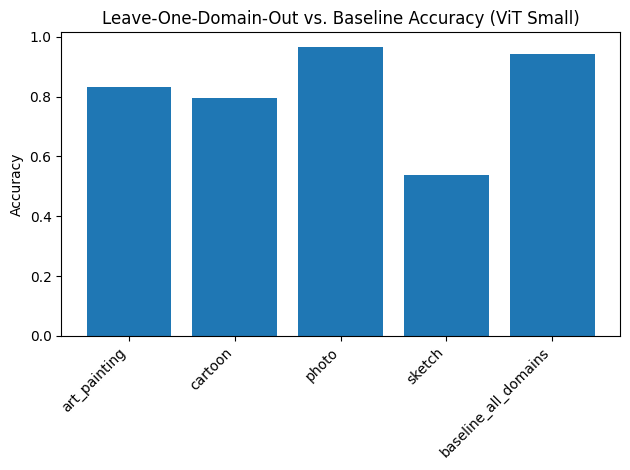

In [19]:
domains = list(results_small.keys())
accuracies = [results_small[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy (ViT Small)')
plt.tight_layout()
plt.show()

## Final Results

In [20]:
print("\Final Results (LODO Accuracy):")
for domain, acc in results_small.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_small.values()) / len(results_small)
print(f"\nAverage Accuracy: {avg_acc:.4f}")

\Final Results (LODO Accuracy):
art_painting: 0.8317
cartoon: 0.7953
photo: 0.9671
sketch: 0.5382
baseline_all_domains: 0.9425

Average Accuracy: 0.8149


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_14976\58557357.py:1: SyntaxWarning: invalid escape sequence '\F'
  print("\Final Results (LODO Accuracy):")


# WinKawaks/ViT Tiny

## Leave-One-Domain-Out (LODO) Training

In [21]:
# WinKawaks/ViT Tiny
# Leave-One-Domain-Out (LODO) Training

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

results_tiny = {}

for test_domain in DOMAINS:
    print(f"\nTesting on domain: {test_domain}")
    train_domains = [d for d in DOMAINS if d != test_domain]

    # Load datasets
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)

    # Concatenate datasets
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, and criterion
    model_tiny = ViTModel(NUM_CLASSES, model_size="tiny")
    # CORRECTED: Optimizer now uses parameters from model_tiny, not model_base.
    optimizer = optim.Adam(model_tiny.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model_tiny, optimizer, criterion)

    # Train
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        train_loss_tiny = trainer.train(train_loader)
        val_acc_tiny = trainer.evaluate(val_loader)
        print(f"Train Loss: {train_loss_tiny:.4f} | Val Acc: {val_acc_tiny:.4f}")

    # Test
    test_acc_tiny = trainer.evaluate(test_loader)
    results_tiny[test_domain] = test_acc_tiny
    print(f"Test Accuracy on {test_domain}: {test_acc_tiny:.4f}")


Testing on domain: art_painting


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 265/265 [00:12<00:00, 21.09it/s]


Train Loss: 1.0774 | Val Acc: 0.8490
Epoch 2/5


100%|██████████| 265/265 [00:11<00:00, 22.36it/s]


Train Loss: 0.3931 | Val Acc: 0.9245
Epoch 3/5


100%|██████████| 265/265 [00:12<00:00, 21.87it/s]


Train Loss: 0.2219 | Val Acc: 0.9144
Epoch 4/5


100%|██████████| 265/265 [00:12<00:00, 21.70it/s]


Train Loss: 0.1498 | Val Acc: 0.9132
Epoch 5/5


100%|██████████| 265/265 [00:12<00:00, 21.43it/s]


Train Loss: 0.1495 | Val Acc: 0.8829
Test Accuracy on art_painting: 0.7049

Testing on domain: cartoon


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 255/255 [00:12<00:00, 20.94it/s]


Train Loss: 1.0025 | Val Acc: 0.8902
Epoch 2/5


100%|██████████| 255/255 [00:11<00:00, 21.43it/s]


Train Loss: 0.3751 | Val Acc: 0.9131
Epoch 3/5


100%|██████████| 255/255 [00:11<00:00, 21.48it/s]


Train Loss: 0.2284 | Val Acc: 0.9118
Epoch 4/5


100%|██████████| 255/255 [00:11<00:00, 21.95it/s]


Train Loss: 0.1679 | Val Acc: 0.9000
Epoch 5/5


100%|██████████| 255/255 [00:11<00:00, 21.92it/s]


Train Loss: 0.1253 | Val Acc: 0.9098
Test Accuracy on cartoon: 0.7228

Testing on domain: photo


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 278/278 [00:13<00:00, 21.10it/s]


Train Loss: 1.0994 | Val Acc: 0.8637
Epoch 2/5


100%|██████████| 278/278 [00:12<00:00, 22.30it/s]


Train Loss: 0.4187 | Val Acc: 0.8703
Epoch 3/5


100%|██████████| 278/278 [00:12<00:00, 22.33it/s]


Train Loss: 0.2297 | Val Acc: 0.8811
Epoch 4/5


100%|██████████| 278/278 [00:12<00:00, 22.01it/s]


Train Loss: 0.1907 | Val Acc: 0.8907
Epoch 5/5


100%|██████████| 278/278 [00:12<00:00, 21.79it/s]


Train Loss: 0.1423 | Val Acc: 0.9153
Test Accuracy on photo: 0.9611

Testing on domain: sketch


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 203/203 [00:10<00:00, 19.48it/s]


Train Loss: 0.8500 | Val Acc: 0.9052
Epoch 2/5


100%|██████████| 203/203 [00:09<00:00, 21.11it/s]


Train Loss: 0.2423 | Val Acc: 0.9283
Epoch 3/5


100%|██████████| 203/203 [00:09<00:00, 21.29it/s]


Train Loss: 0.1663 | Val Acc: 0.9382
Epoch 4/5


100%|██████████| 203/203 [00:09<00:00, 20.69it/s]


Train Loss: 0.0850 | Val Acc: 0.9266
Epoch 5/5


100%|██████████| 203/203 [00:09<00:00, 20.52it/s]


Train Loss: 0.0827 | Val Acc: 0.9200
Test Accuracy on sketch: 0.3855


## Baseline

In [22]:
print("\nBaseline: training on all domains and testing on mixed domains")
# Load full train and test sets via leave-all-in loaders
dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]

# Concatenate
full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Initialize baseline model
# CORRECTED: Added model_size="tiny" to ensure the correct model is loaded.
baseline_model_tiny = ViTModel(NUM_CLASSES, model_size="tiny")
baseline_optimizer = optim.Adam(baseline_model_tiny.parameters(), lr=1e-4)
baseline_criterion = nn.CrossEntropyLoss()
baseline_trainer = Trainer(baseline_model_tiny, baseline_optimizer, baseline_criterion)

# Train baseline
for epoch in range(NUM_EPOCHS):
    print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
    baseline_loss_tiny = baseline_trainer.train(full_train_loader)
    baseline_val_acc_tiny = baseline_trainer.evaluate(full_test_loader)
    print(f"Baseline Loss: {baseline_loss_tiny:.4f} | Baseline Acc: {baseline_val_acc_tiny:.4f}")

# Test baseline
baseline_test_acc_tiny = baseline_trainer.evaluate(full_test_loader)
results_tiny['baseline_all_domains'] = baseline_test_acc_tiny
print(f"Baseline Test Accuracy: {baseline_test_acc_tiny:.4f}")


Baseline: training on all domains and testing on mixed domains


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline Epoch 1/5


100%|██████████| 333/333 [00:16<00:00, 20.66it/s]


Baseline Loss: 0.8897 | Baseline Acc: 0.8639
Baseline Epoch 2/5


100%|██████████| 333/333 [00:15<00:00, 21.69it/s]


Baseline Loss: 0.3344 | Baseline Acc: 0.9145
Baseline Epoch 3/5


100%|██████████| 333/333 [00:15<00:00, 21.21it/s]


Baseline Loss: 0.1918 | Baseline Acc: 0.9070
Baseline Epoch 4/5


100%|██████████| 333/333 [00:15<00:00, 21.74it/s]


Baseline Loss: 0.1571 | Baseline Acc: 0.8829
Baseline Epoch 5/5


100%|██████████| 333/333 [00:15<00:00, 21.46it/s]


Baseline Loss: 0.1107 | Baseline Acc: 0.9205
Baseline Test Accuracy: 0.9205


## Visual Comparison

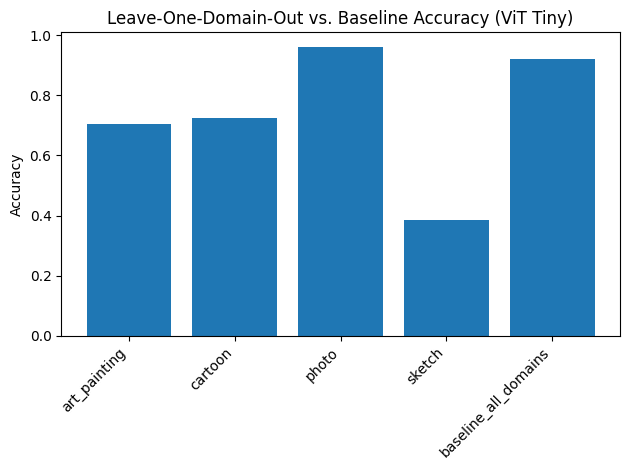

In [23]:
domains = list(results_tiny.keys())
accuracies = [results_tiny[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy (ViT Tiny)')
plt.tight_layout()
plt.show()

## Final Results

In [24]:
print("\Final Results (LODO Accuracy):")
for domain, acc in results_tiny.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_tiny.values()) / len(results_tiny)
print(f"\nAverage Accuracy: {avg_acc:.4f}")

\Final Results (LODO Accuracy):
art_painting: 0.7049
cartoon: 0.7228
photo: 0.9611
sketch: 0.3855
baseline_all_domains: 0.9205

Average Accuracy: 0.7389


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_14976\2674563202.py:1: SyntaxWarning: invalid escape sequence '\F'
  print("\Final Results (LODO Accuracy):")


# Performance Comparison

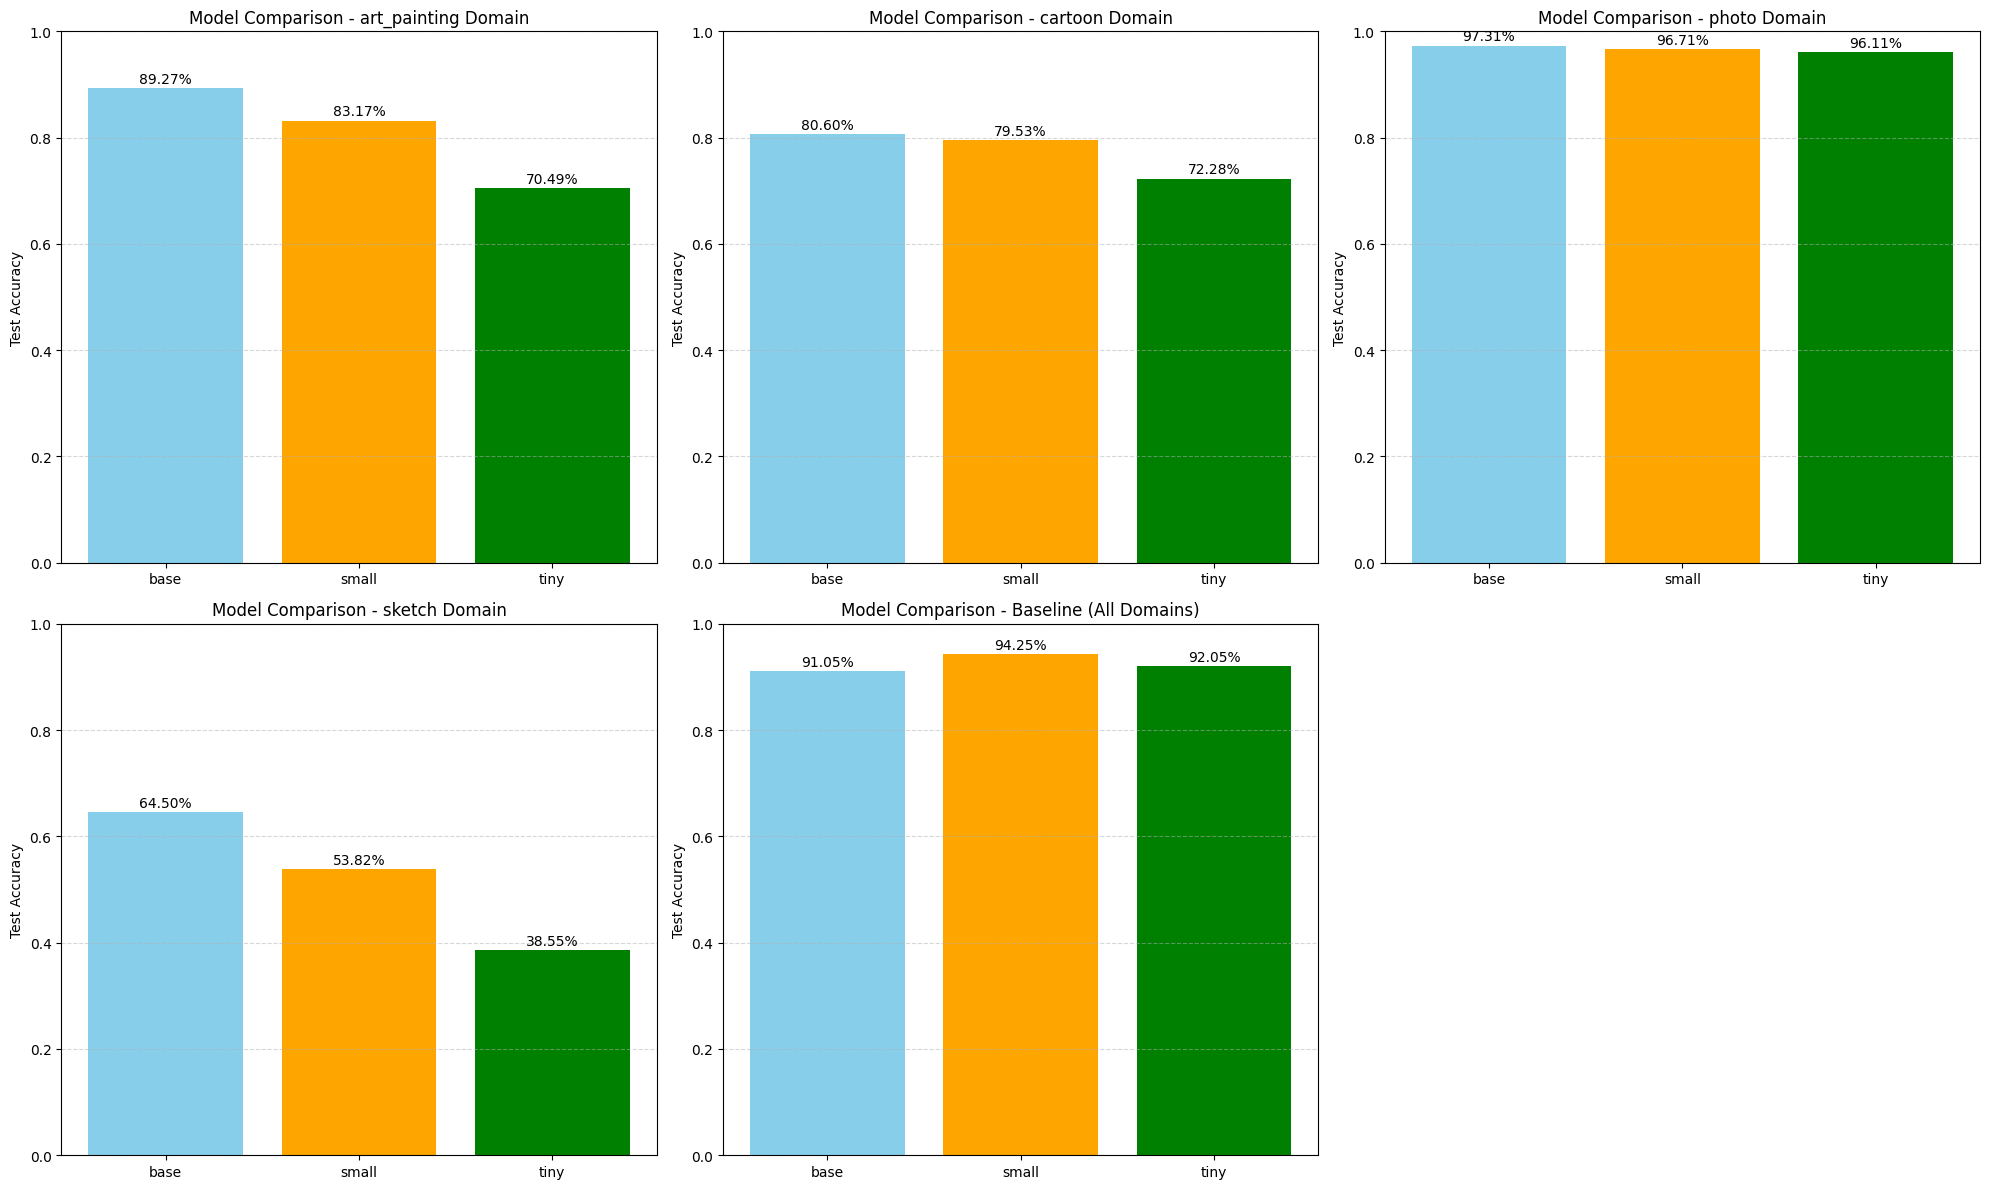


Detailed Performance Comparison:
------------------------------------------------------------
Domain                Base      Small       Tiny
------------------------------------------------------------
art_painting        89.27%     83.17%     70.49%
cartoon             80.60%     79.53%     72.28%
photo               97.31%     96.71%     96.11%
sketch              64.50%     53.82%     38.55%
------------------------------------------------------------
Baseline            91.05%     94.25%     92.05%
------------------------------------------------------------


In [25]:
plt.figure(figsize=(20, 12))

for idx, domain in enumerate(DOMAINS):
    plt.subplot(2, 3, idx + 1)

    domain_accuracies = [
        results_base[domain],
        results_small[domain],
        results_tiny[domain]
    ]

    bars = plt.bar(MODELS.keys(), domain_accuracies, color=["skyblue", "orange", "green"])
    plt.ylim(0, 1)
    plt.ylabel("Test Accuracy")
    plt.title(f"Model Comparison - {domain} Domain")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    
    # Add value labels on top of bars
    for i, acc in enumerate(domain_accuracies):
        plt.text(i, acc + 0.01, f"{acc:.2%}", ha="center")

# Create the baseline comparison subplot
plt.subplot(2, 3, 5) 
baseline_accuracies = [
    results_base["baseline_all_domains"],
    results_small["baseline_all_domains"],
    results_tiny["baseline_all_domains"]
]
plt.bar(MODELS.keys(), baseline_accuracies, color=["skyblue", "orange", "green"])
plt.ylim(0, 1)
plt.ylabel("Test Accuracy")
plt.title("Model Comparison - Baseline (All Domains)")
plt.grid(axis="y", linestyle="--", alpha=0.5)

for i, acc in enumerate(baseline_accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2%}", ha="center")

plt.tight_layout()
plt.show()

print("\nDetailed Performance Comparison:")
print("-" * 60)
print(f"{'Domain':<15} {'Base':>10} {'Small':>10} {'Tiny':>10}")
print("-" * 60)

for domain in DOMAINS:
    print(f"{domain:<15} {results_base[domain]:>10.2%} {results_small[domain]:>10.2%} {results_tiny[domain]:>10.2%}")

print("-" * 60)
print(f"{'Baseline':<15} {results_base['baseline_all_domains']:>10.2%} {results_small['baseline_all_domains']:>10.2%} {results_tiny['baseline_all_domains']:>10.2%}")
print("-" * 60)